## Imports 

In [9]:
import numpy as np
import keras
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import tensorflow as tf
from datetime import datetime, timedelta
import os
cutoff_date = '2015-01-01'

## Getting data from yfinance

In [ ]:
ticker = 'AAPL'

stockDataName = f'{ticker}_StockData.csv'
end_date = datetime.today()
# print(end_date)
start_date = end_date - timedelta(days=365 * 30)
# print(start_date)
data = yf.download(ticker, start=start_date, end=end_date)
output_path = os.path.join(os.getcwd(), 'dataset', stockDataName)
data.to_csv(output_path)

[*********************100%***********************]  1 of 1 completed


## Cleaning data

In [67]:
# # Load data and parse dates
df = pd.read_csv(f'dataset/{stockDataName}', skiprows=[1, 2], parse_dates=['Price'])

# # Rename 'Price' to 'Date'
df = df.rename(columns={'Price': 'Date'})
df = df.set_index('Date')
# df = pd.read_csv(f'dataset/AAPL_CleanedStockData.csv', parse_dates=['Date'])


print(df.head())  # Check the first few rows
print(df.isnull().sum())  # Check for missing values

df = df.drop('Volume', axis=1)  # Drop the 'Volume' column

df['Range'] = df['High'] - df['Low']  # Create a new column 'Range'
df = df.drop(['High', 'Low'], axis=1)  # Drop the 'High' and 'Low' columns

# Calculate the 20-day moving average
df['MA20'] = df['Close'].rolling(window=20).mean()
# Calculate the 50-day moving average
df['MA50'] = df['Close'].rolling(window=50).mean()
df = df.dropna().copy() # Keep Date column



# Fill missing values

# Generate a complete date range and forward-fill missing values
df = df.asfreq('D', method='ffill')  # Forward-fill prices on non-trading days
df = df[~df.index.duplicated(keep='first')]  # Remove duplicate dates

# Save cleaned data to a new file
cleanedStockDataName = f'{ticker}_CleanedStockData.csv'
df.to_csv(f'dataset/{cleanedStockDataName}')

               Close      High       Low      Open     Volume
Date                                                         
1995-05-12  0.325396  0.325862  0.302087  0.304884  647953600
1995-05-15  0.325396  0.326328  0.317004  0.321667  393355200
1995-05-16  0.326328  0.330990  0.317004  0.321667  332516800
1995-05-17  0.328193  0.330990  0.324464  0.326328  263144000
1995-05-18  0.323531  0.329125  0.322599  0.329125  371571200
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64


## Defining the function to build the model

In [68]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, LSTM, Dropout, BatchNormalization,
    AdditiveAttention, Dense, Flatten, Permute, Reshape, Multiply
)
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt

features = ['Close', 'Open', 'Range', 'MA20', 'MA50']


def train_lstm_model_with_trend_filter(
    csv_path,
    sequence_length=100,
    batch_size=25,
    epochs=100,
    validation_split=0.2,
    patience=10,
    cutoff_date='2015-01-01',
    filter_by_trend=None  # 'bull', 'bear', or None
):
    """
    Trains an LSTM model with attention mechanism on stock Close price data.
    Optionally filters training data by market trend (MA20 > MA50 or <=).

    Returns:
        model, history, close_scaler, input_scaler
    """
    print(f"Loading data after {cutoff_date}, trend filter: {filter_by_trend}")
    df = pd.read_csv(csv_path)
    df = df[df['Date'] >= cutoff_date].reset_index(drop=True)

    if filter_by_trend == 'bull':
        df = df[df['MA20'] > df['MA50']]
    elif filter_by_trend == 'bear':
        df = df[df['MA20'] <= df['MA50']]

    df = df.drop(columns=['Date'])
    if len(df) <= sequence_length:
        raise ValueError("Not enough data points after filtering.")

    # --- Scaling ---
    input_scaler = MinMaxScaler()
    input_scaled = input_scaler.fit_transform(df[features])
    close_scaler = MinMaxScaler()
    close_scaled = close_scaler.fit_transform(df[['Close']])

    # --- Create Sequences ---
    X, y = [], []
    for i in range(sequence_length, len(input_scaled)):
        X.append(input_scaled[i-sequence_length:i])
        y.append(close_scaled[i, 0])
    X, y = np.array(X), np.array(y)

    # --- Train/Test Split ---
    train_size = int(0.8 * len(X))
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # --- Model ---
    input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
    x = LSTM(50, return_sequences=True)(input_layer)
    x = Dropout(0.2)(x)
    x = BatchNormalization()(x)
    x = LSTM(50, return_sequences=True)(x)

    # Attention
    x_perm = Permute((2, 1))(x)
    x_reshape = Reshape((50, X_train.shape[1]))(x_perm)
    attn = AdditiveAttention()([x_reshape, x_reshape])
    attn = Permute((2, 1))(attn)
    attn = Reshape((X_train.shape[1], 50))(attn)

    x = Multiply()([x, attn])
    x = Flatten()(x)
    output = Dense(1)(x)

    model = Model(inputs=input_layer, outputs=output)
    model.compile(optimizer='adam', loss='mean_squared_error')

    # --- Callbacks ---
    early_stopping = EarlyStopping(
        monitor='val_loss', patience=patience, restore_best_weights=True)
    csv_logger = CSVLogger('training_log.csv')

    # --- Train ---
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=validation_split,
        callbacks=[early_stopping, csv_logger]
    )

    # --- Evaluate ---
    y_pred = model.predict(X_test)
    y_pred_real = close_scaler.inverse_transform(y_pred)
    y_test_real = close_scaler.inverse_transform(y_test.reshape(-1, 1))

    mae_real = mean_absolute_error(y_test_real, y_pred_real)
    rmse_real = np.sqrt(mean_squared_error(y_test_real, y_pred_real))
    print(f"Real MAE: ${mae_real:.2f}, RMSE: ${rmse_real:.2f}")

    return model, history, close_scaler, input_scaler



def plot_training_history(history, save_path=None):
    """
    Plots the training and validation loss from a Keras model history.

    Args:
        history: History object returned by model.fit()
        save_path (str, optional): If provided, saves the plot to this filepath.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
    plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    plt.title('Training vs Validation Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')  # Save the plot
        print(f"Training history plot saved to {save_path}")

    plt.show()

In [ ]:
import os
import joblib

def save_model_and_scalers(model, close_scaler, input_scaler, prefix):
    """
    Saves the model and scalers with the specified prefix.
    
    Args:
        model: Trained Keras model.
        close_scaler: Scaler used for Close price.
        input_scaler: Scaler used for input features.
        prefix (str): Prefix to use for filenames (e.g., 'bull', 'bear').
    """
    os.makedirs("models", exist_ok=True)
    
    model_path = f"models/{prefix}_model.keras"
    close_scaler_path = f"models/{prefix}_close_scaler.save"
    input_scaler_path = f"models/{prefix}_input_scaler.save"
    
    model.save(model_path)
    joblib.dump(close_scaler, close_scaler_path)
    joblib.dump(input_scaler, input_scaler_path)
    
    print(f"Saved model to {model_path}")
    print(f"Saved close scaler to {close_scaler_path}")
    print(f"Saved input scaler to {input_scaler_path}")

## Building the model

Loading data after 2015-01-01, trend filter: bull
Epoch 1/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - loss: 0.0088 - val_loss: 0.2333
Epoch 2/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0013 - val_loss: 0.2128
Epoch 3/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 7.9556e-04 - val_loss: 0.2270
Epoch 4/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 4.9351e-04 - val_loss: 0.2169
Epoch 5/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 5.5552e-04 - val_loss: 0.1727
Epoch 6/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 3.5667e-04 - val_loss: 0.1817
Epoch 7/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 4.4375e-04 - val_loss: 0.1214
Epoch 8/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 3.0593e-04 - val_loss: 0.0746
Epoch 9/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 3.2086e-04 - val_loss: 0.0559
Epoch 10/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 2.4510e-04 - val_loss: 0.0235
Epoch 11/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - lo

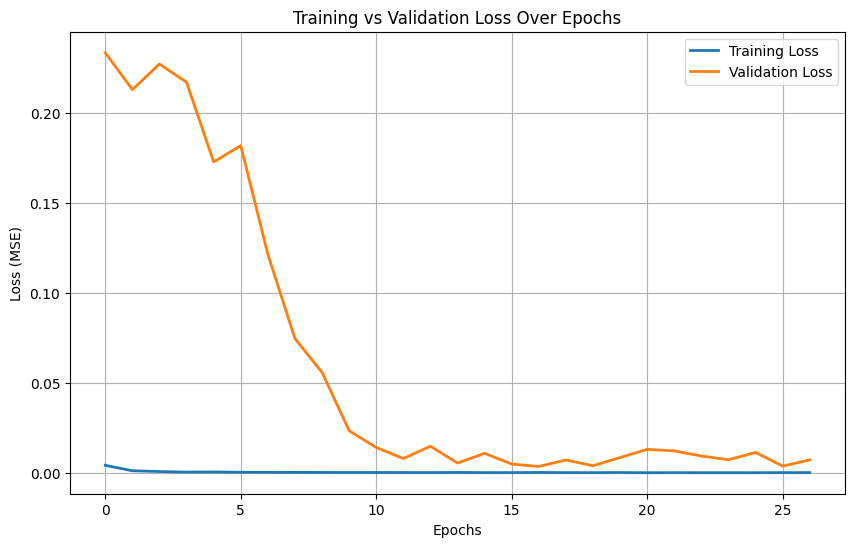

Loading data after 2015-01-01, trend filter: bear
Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 0.0211 - val_loss: 0.1572
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0031 - val_loss: 0.1438
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0029 - val_loss: 0.1330
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0021 - val_loss: 0.1031
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0017 - val_loss: 0.0955
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0013 - val_loss: 0.1023
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0027 - val_loss: 0.1207
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 8.6625e-04 - val_loss: 0.1236
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0011 - val_loss: 0.1201
Epoch 10/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 8.5147e-04 - val_loss: 0.0756
Epoch 11/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 6.4625e-04 - val_los

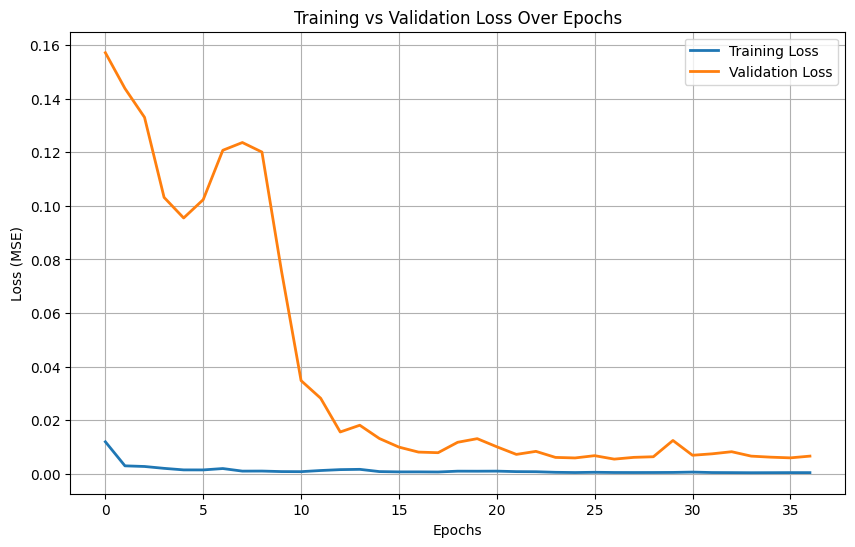

Saved model to models/bull_model.keras
Saved close scaler to models/bull_close_scaler.save
Saved input scaler to models/bull_input_scaler.save
Saved model to models/bear_model.keras
Saved close scaler to models/bear_close_scaler.save
Saved input scaler to models/bear_input_scaler.save


In [70]:
# model, history, close_scaler, input_scaler = train_lstm_model(
#     csv_path="dataset/AAPL_CleanedStockData.csv",
#     sequence_length=100,
#     batch_size=25,
#     epochs=100,
#     validation_split=0.2,
#     patience=10,
#     cutoff_date=cutoff_date
# )

# # === Save the trained model ===
# model.save("models/lstm_attention_model.keras")
# print("Model saved to models/lstm_attention_model.keras")

# === Plot and save training history ===
# plot_training_history(history, save_path="training_history.png")

bull_model, bull_history, bull_close_scaler, bull_input_scaler = train_lstm_model_with_trend_filter(
    csv_path='dataset/AAPL_CleanedStockData.csv',
    filter_by_trend='bull'
)
plot_training_history(bull_history, save_path="bull_training_history.png")

bear_model, bear_history, bear_close_scaler, bear_input_scaler = train_lstm_model_with_trend_filter(
    csv_path='dataset/AAPL_CleanedStockData.csv',
    filter_by_trend='bear'
)
plot_training_history(bear_history, save_path="bear_training_history.png")
save_model_and_scalers(bull_model, bull_close_scaler,
                       bull_input_scaler, "bull")
save_model_and_scalers(bear_model, bear_close_scaler,
                       bear_input_scaler, "bear")

# Evaluating: 

68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


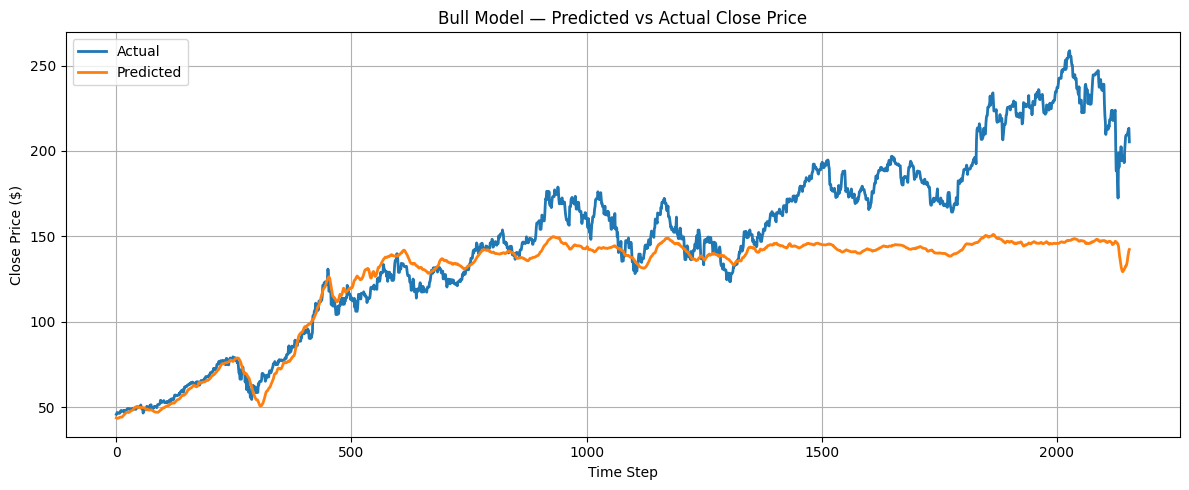

--- Bull Model ---
Mean Actual Price: $146.98
MAE: $24.70 (16.80%)
RMSE: $36.79 (25.03%)

68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


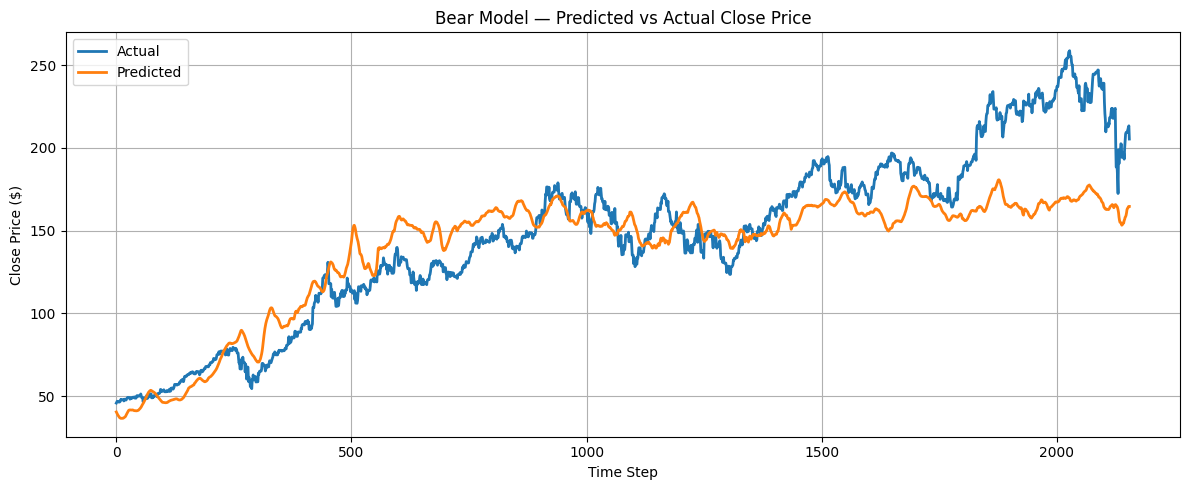

--- Bear Model ---
Mean Actual Price: $146.98
MAE: $20.89 (14.22%)
RMSE: $28.22 (19.20%)



In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import load_model
import joblib

# === SETTINGS ===
csv_path = 'dataset/AAPL_CleanedStockData.csv'
features = ['Close', 'Open', 'Range', 'MA20', 'MA50']
sequence_length = 100

# === Load and prepare data ===
df = pd.read_csv(csv_path).drop(columns=['Date'])
input_data = df[features]

# === Load all models and scalers ===
bull_model = load_model('models/bull_model.keras')
bear_model = load_model('models/bear_model.keras')

bull_close_scaler = joblib.load('models/bull_close_scaler.save')
bear_close_scaler = joblib.load('models/bear_close_scaler.save')

bull_input_scaler = joblib.load('models/bull_input_scaler.save')
bear_input_scaler = joblib.load('models/bear_input_scaler.save')

# === Preprocess ===
bull_input_scaled = bull_input_scaler.transform(input_data)
bear_input_scaled = bear_input_scaler.transform(input_data)

bull_close_scaled = bull_close_scaler.transform(df[['Close']])
bear_close_scaled = bear_close_scaler.transform(df[['Close']])

# === Build sequences ===


def build_sequences(input_scaled, close_scaled):
    X, y = [], []
    for i in range(sequence_length, len(input_scaled)):
        X.append(input_scaled[i-sequence_length:i])
        y.append(close_scaled[i, 0])
    return np.array(X), np.array(y)


X_bull, y_bull = build_sequences(bull_input_scaled, bull_close_scaled)
X_bear, y_bear = build_sequences(bear_input_scaled, bear_close_scaled)

# === Evaluate each model on last 20% ===


def evaluate(model, X, y, scaler, label):
    test_size = int(len(X) * 0.2)
    X_test = X[-test_size:]
    y_test = y[-test_size:]

    y_pred_scaled = model.predict(X_test)
    y_pred_real = scaler.inverse_transform(y_pred_scaled)
    y_test_real = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Plot
    plt.figure(figsize=(12, 5))
    plt.plot(y_test_real, label='Actual', linewidth=2)
    plt.plot(y_pred_real, label='Predicted', linewidth=2)
    plt.title(f'{label.capitalize()} Model — Predicted vs Actual Close Price')
    plt.xlabel('Time Step')
    plt.ylabel('Close Price ($)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Metrics
    mean_price = np.mean(y_test_real)
    mae = mean_absolute_error(y_test_real, y_pred_real)
    rmse = np.sqrt(mean_squared_error(y_test_real, y_pred_real))
    percent_mae = (mae / mean_price) * 100
    percent_rmse = (rmse / mean_price) * 100

    print(f"--- {label.capitalize()} Model ---")
    print(f"Mean Actual Price: ${mean_price:.2f}")
    print(f"MAE: ${mae:.2f} ({percent_mae:.2f}%)")
    print(f"RMSE: ${rmse:.2f} ({percent_rmse:.2f}%)")
    print()


# === Run evaluations ===
evaluate(bull_model, X_bull, y_bull, bull_close_scaler, label='bull')
evaluate(bear_model, X_bear, y_bear, bear_close_scaler, label='bear')

115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


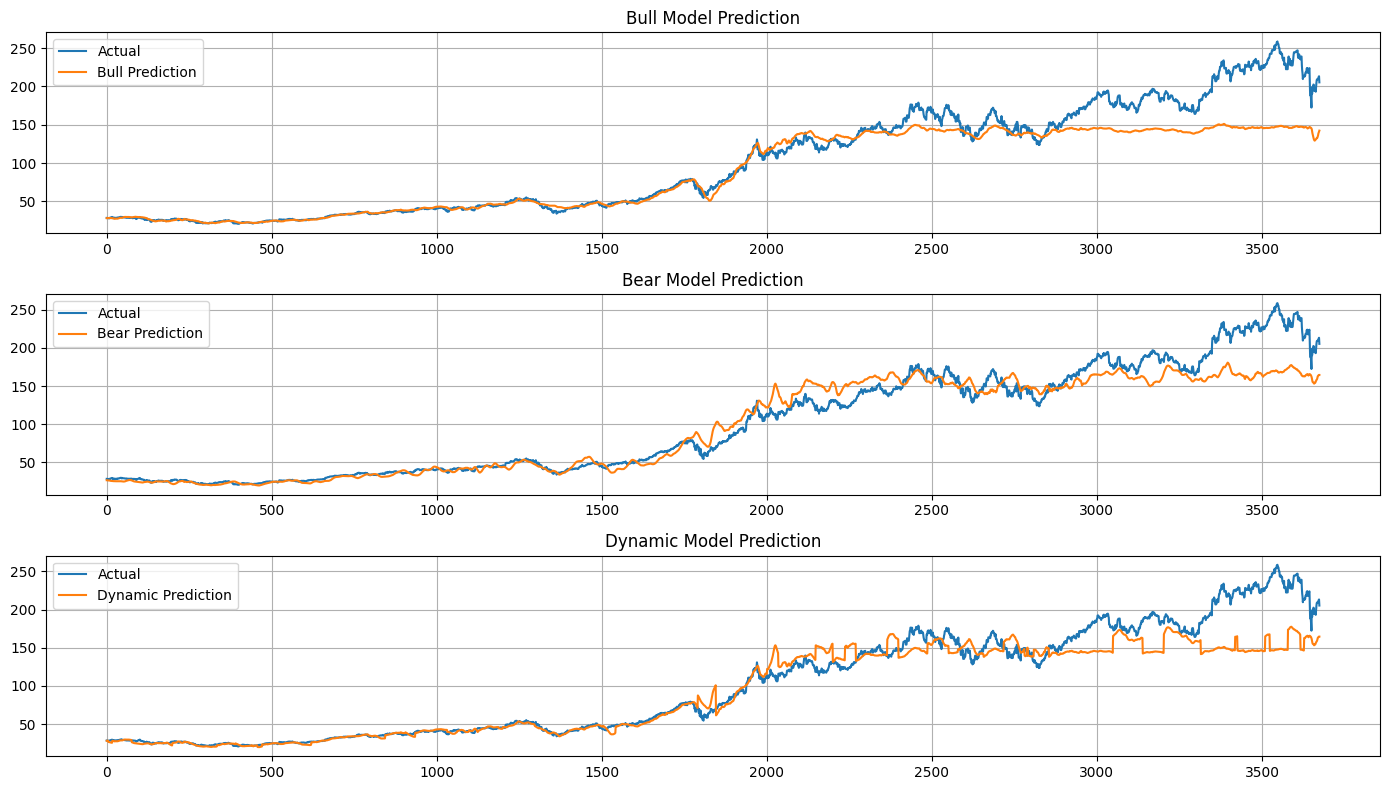


Bull Model:
MAE: $15.05 (15.00%)
RMSE: $28.20 (28.11%)

Bear Model:
MAE: $13.30 (13.26%)
RMSE: $21.71 (21.64%)

Dynamic Model:
MAE: $14.11 (14.07%)
RMSE: $25.97 (25.89%)


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib

# === SETTINGS ===
csv_path = 'dataset/AAPL_CleanedStockData.csv'
sequence_length = 100
features = ['Close', 'Open', 'Range', 'MA20', 'MA50']

# === Load data ===
df = pd.read_csv(csv_path)
df = df[df['Date'] >= '2015-01-01'].reset_index(drop=True)
data = df.drop(columns=['Date'])

# === Load models and scalers ===
bull_model = load_model('models/bull_model.keras')
bear_model = load_model('models/bear_model.keras')
bull_close_scaler = joblib.load('models/bull_close_scaler.save')
bull_input_scaler = joblib.load('models/bull_input_scaler.save')
bear_close_scaler = joblib.load('models/bear_close_scaler.save')
bear_input_scaler = joblib.load('models/bear_input_scaler.save')

# === Scale data ===
bull_input_scaled = bull_input_scaler.transform(data[features])
bull_close_scaled = bull_close_scaler.transform(data[['Close']])
bear_input_scaled = bear_input_scaler.transform(data[features])
bear_close_scaled = bear_close_scaler.transform(data[['Close']])

# === Create sequences and labels ===


def create_sequences(input_scaled, close_scaled):
    X, y = [], []
    for i in range(sequence_length, len(input_scaled)):
        X.append(input_scaled[i-sequence_length:i])
        y.append(close_scaled[i, 0])
    return np.array(X), np.array(y)


X_bull, y_bull = create_sequences(bull_input_scaled, bull_close_scaled)
X_bear, y_bear = create_sequences(bear_input_scaled, bear_close_scaled)
dates = df['Date'].values[sequence_length:]  # for plotting

# === Dynamic routing logic ===
ma_diff = data['MA20'] - data['MA50']
signals = ma_diff[sequence_length:] > 0  # True = Bull, False = Bear

# --- Predict using each model ---
y_pred_bull = bull_model.predict(X_bull)
y_pred_bear = bear_model.predict(X_bear)

# --- Actual Close ---
actual_close = bull_close_scaler.inverse_transform(y_bull.reshape(-1, 1))

# --- Inverse transform ---
pred_bull_real = bull_close_scaler.inverse_transform(y_pred_bull)
pred_bear_real = bear_close_scaler.inverse_transform(y_pred_bear)

# --- Dynamic selection ---
pred_dynamic = np.where(
    signals.to_numpy()[:, None], pred_bull_real, pred_bear_real)


# === Plot results ===
plt.figure(figsize=(14, 8))

# Bull model
plt.subplot(3, 1, 1)
plt.plot(actual_close, label='Actual')
plt.plot(pred_bull_real, label='Bull Prediction')
plt.title('Bull Model Prediction')
plt.legend()
plt.grid(True)

# Bear model
plt.subplot(3, 1, 2)
plt.plot(actual_close, label='Actual')
plt.plot(pred_bear_real, label='Bear Prediction')
plt.title('Bear Model Prediction')
plt.legend()
plt.grid(True)

# Dynamic model
plt.subplot(3, 1, 3)
plt.plot(actual_close, label='Actual')
plt.plot(pred_dynamic, label='Dynamic Prediction')
plt.title('Dynamic Model Prediction')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# === Metrics ===


def print_metrics(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mean_price = np.mean(y_true)
    print(f"\n{name} Model:")
    print(f"MAE: ${mae:.2f} ({(mae/mean_price)*100:.2f}%)")
    print(f"RMSE: ${rmse:.2f} ({(rmse/mean_price)*100:.2f}%)")


print_metrics("Bull", actual_close, pred_bull_real)
print_metrics("Bear", actual_close, pred_bear_real)
print_metrics("Dynamic", actual_close, pred_dynamic)

In [4]:
def predict_next_day_price(current_date: str):
    import pandas as pd
    import numpy as np
    import joblib
    from tensorflow.keras.models import load_model

    sequence_length = 100
    features = ['Close', 'Open', 'Range', 'MA20', 'MA50']

    # === Load models and scalers ===
    bull_model = load_model('models/bull_model.keras')
    bear_model = load_model('models/bear_model.keras')
    bull_close_scaler = joblib.load('models/bull_close_scaler.save')
    bear_close_scaler = joblib.load('models/bear_close_scaler.save')
    input_scaler = joblib.load(
        'models/bull_input_scaler.save')  # shared input scaler

    # === Load and prepare dataset ===
    df = pd.read_csv('dataset/AAPL_CleanedStockData.csv', parse_dates=['Date'])
    df = df.sort_values('Date').reset_index(drop=True)

    # === Locate the current date ===
    idx = df.index[df['Date'] == pd.to_datetime(current_date)]
    if idx.empty or idx[0] < sequence_length or idx[0] + 1 >= len(df):
        raise ValueError(
            "Invalid current_date — must be at least 100 days into dataset and not the last date.")

    target_idx = idx[0]

    # === Prepare input sequence ===
    window_df = df.iloc[target_idx - sequence_length:target_idx]
    input_features = input_scaler.transform(window_df[features])
    input_sequence = input_features.reshape(1, sequence_length, len(features))

    # === Choose model based on MA trend ===
    ma20 = df.loc[target_idx, 'MA20']
    ma50 = df.loc[target_idx, 'MA50']
    use_bull = ma20 > ma50

    # === Predict with bull and bear models ===
    pred_bull_scaled = bull_model.predict(input_sequence)[0, 0]
    pred_bear_scaled = bear_model.predict(input_sequence)[0, 0]

    pred_bull = bull_close_scaler.inverse_transform([[pred_bull_scaled]])[0, 0]
    pred_bear = bear_close_scaler.inverse_transform([[pred_bear_scaled]])[0, 0]
    pred_dynamic = pred_bull if use_bull else pred_bear

    # === Get actual price of the next day ===
    next_day_date = df.iloc[target_idx + 1]['Date'].date()
    actual_price = df.iloc[target_idx + 1]['Close']

    # === Output ===
    print(f"📅 Predicting Close on {next_day_date}")
    print(f"🐂 Bull Model:    ${pred_bull:.2f}")
    print(f"🐻 Bear Model:    ${pred_bear:.2f}")
    print(f"🔀 Dynamic Used:  {'Bull' if use_bull else 'Bear'}")
    print(f"🎯 Prediction:    ${pred_dynamic:.2f}")
    print(f"✅ Actual Close:  ${actual_price:.2f}")
    print(f"📉 Absolute Error:  ${abs(pred_dynamic - actual_price):.2f}")
    print(
        f"🔍 Relative Error:  {(abs(pred_dynamic - actual_price) / actual_price) * 100:.2f}%")

    return {
        "pred_bull": pred_bull,
        "pred_bear": pred_bear,
        "pred_dynamic": pred_dynamic,
        "actual_price": actual_price,
        "next_day_date": next_day_date,
        "used_model": "bull" if use_bull else "bear",
        "error": abs(pred_dynamic - actual_price),
        "relative_error": (abs(pred_dynamic - actual_price) / actual_price) * 100
    }

In [5]:
predict_next_day_price("2025-03-02")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
📅 Predicting Close on 2025-03-03
🐂 Bull Model:    $147.27
🐻 Bear Model:    $161.89
🔀 Dynamic Used:  Bear
🎯 Prediction:    $161.89
✅ Actual Close:  $238.03
📉 Absolute Error:  $76.14
🔍 Relative Error:  31.99%


{'pred_bull': np.float64(147.26970917123208),
 'pred_bear': np.float64(161.89175888082536),
 'pred_dynamic': np.float64(161.89175888082536),
 'actual_price': np.float64(238.02999877929688),
 'next_day_date': datetime.date(2025, 3, 3),
 'used_model': 'bear',
 'error': np.float64(76.13823989847151),
 'relative_error': np.float64(31.98682531148834)}

In [6]:
def evaluate_random_predictions_dual_model(
    csv_path='dataset/AAPL_CleanedStockData.csv',
    cutoff_date='2015-01-01',
    num_samples=10,
    sequence_length=100
):
    import pandas as pd
    import numpy as np
    import joblib
    from tensorflow.keras.models import load_model
    from random import sample

    features = ['Close', 'Open', 'Range', 'MA20', 'MA50']

    # Load models and scalers
    bull_model = load_model('models/bull_model.keras')
    bear_model = load_model('models/bear_model.keras')
    bull_close_scaler = joblib.load('models/bull_close_scaler.save')
    bear_close_scaler = joblib.load('models/bear_close_scaler.save')
    input_scaler = joblib.load(
        'models/bull_input_scaler.save')  # shared input scaler

    # Load and filter data
    df = pd.read_csv(csv_path, parse_dates=['Date'])
    df = df.sort_values('Date').reset_index(drop=True)
    df = df[df['Date'] >= pd.to_datetime(cutoff_date)].reset_index(drop=True)

    if len(df) <= sequence_length + 1:
        raise ValueError("Not enough data after cutoff_date to sample.")

    # Sample indices
    valid_indices = list(range(sequence_length, len(df) - 1))
    selected_indices = sample(valid_indices, min(
        num_samples, len(valid_indices)))

    results = []

    for idx in selected_indices:
        window_df = df.iloc[idx-sequence_length:idx]
        input_features = input_scaler.transform(window_df[features])
        input_seq = input_features.reshape(1, sequence_length, len(features))

        # Decide which model to use
        ma20 = df.loc[idx, 'MA20']
        ma50 = df.loc[idx, 'MA50']
        use_bull = ma20 > ma50

        if use_bull:
            pred_scaled = bull_model.predict(input_seq)[0, 0]
            predicted_price = bull_close_scaler.inverse_transform([[pred_scaled]])[
                0, 0]
            model_used = 'Bull'
        else:
            pred_scaled = bear_model.predict(input_seq)[0, 0]
            predicted_price = bear_close_scaler.inverse_transform([[pred_scaled]])[
                0, 0]
            model_used = 'Bear'

        actual_price = df.iloc[idx + 1]['Close']
        predict_for_date = df.iloc[idx + 1]['Date'].date()

        results.append({
            'Date': predict_for_date,
            'Model Used': model_used,
            'Predicted': predicted_price,
            'Actual': actual_price,
            'Absolute Error': abs(predicted_price - actual_price),
            'Relative Error (%)': abs(predicted_price - actual_price) / actual_price * 100
        })

    return pd.DataFrame(results).sort_values('Date').reset_index(drop=True)

In [10]:
results = evaluate_random_predictions_dual_model(cutoff_date=cutoff_date)
display(results)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


,Date,Model Used,Predicted,Actual,Absolute Error,Relative Error (%)
0,2016-09-17,Bull,23.989035,26.442198,2.453163,9.277453
1,2017-11-29,Bull,41.832800,39.826561,2.006239,5.037439
2,2019-03-15,Bull,43.677833,44.583862,0.906030,2.032192
3,2019-10-17,Bull,54.146539,56.791824,2.645285,4.657863
4,2020-11-25,Bull,131.190143,113.335907,17.854236,15.753380
5,2022-09-18,Bull,145.843473,148.721252,2.877779,1.935015
6,2023-05-11,Bull,145.598172,172.015259,26.417087,15.357409
7,2023-05-19,Bull,144.221724,173.651047,29.429323,16.947392
8,2024-03-16,Bear,156.238361,171.808731,15.570370,9.062618
9,2024-09-17,Bull,145.498880,216.313904,70.815024,32.737158
